# DDCGAN-based Fusion Model Testing

This notebook tests the trained DDCGAN-based CT-MRI fusion model with comprehensive evaluation metrics and visualizations.

In [25]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from typing import Tuple, Dict, Any
from pathlib import Path
import sys

# Add path to utils for metrics
sys.path.append('./utils')
from metrics import evaluate_fusion_comprehensive, get_metric_descriptions

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [26]:
# DDCGAN Model Architecture (updated to match current training version)
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel=3):
        super().__init__()
        padding = kernel // 2
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class Encoder(nn.Module):
    def __init__(self, in_channels=2, feat=48):
        super().__init__()
        self.net = nn.Sequential(
            Block(in_channels, feat, stride=1),
            Block(feat, feat, stride=2),
            Block(feat, feat, stride=1),
            Block(feat, feat, stride=2),
            Block(feat, feat, stride=1)
        )
    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, in_channels=48, out_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(16, out_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

class Generator(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, feat=48):
        super().__init__()
        self.encoder = Encoder(in_channels, feat)
        self.decoder = Decoder(feat, out_channels)
    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out

In [27]:
# Dataset class for paired CT-MRI images (updated to match current training version)
class CTMRIDataset(Dataset):
    """
    Expects dataset_path to contain two folders:
      - CT/   -> contains CT images
      - MRI/  -> contains MRI images
    Filenames must match for pairing (or sorted order used).
    """
    def __init__(self, dataset_path, transform=None, img_size=(256,256), extensions=('.png','.jpg','.jpeg','.bmp','.tif')):
        super().__init__()
        self.dataset_path = Path(dataset_path)
        self.ct_dir = self.dataset_path / "CT"
        self.mri_dir = self.dataset_path / "MRI"
        self.transform = transform
        self.img_size = img_size
        self.extensions = extensions

        if not self.ct_dir.exists() or not self.mri_dir.exists():
            raise RuntimeError(f"CT or MRI folder missing in {dataset_path}. Expected 'CT' and 'MRI' subfolders.")

        # list and pair based on sorted filenames
        self.ct_files = sorted([p for p in self.ct_dir.iterdir() if p.suffix.lower() in extensions])
        self.mri_files = sorted([p for p in self.mri_dir.iterdir() if p.suffix.lower() in extensions])

        if len(self.ct_files) == 0 or len(self.mri_files) == 0:
            raise RuntimeError("No images found in CT/ or MRI/ subfolders.")

        # If counts differ, pair until min length and warn
        if len(self.ct_files) != len(self.mri_files):
            print(f"Warning: CT and MRI counts differ ({len(self.ct_files)} vs {len(self.mri_files)}). Pairing up to min length.")
            min_len = min(len(self.ct_files), len(self.mri_files))
            self.ct_files = self.ct_files[:min_len]
            self.mri_files = self.mri_files[:min_len]

    def __len__(self):
        return len(self.ct_files)

    def _load_image(self, path):
        # Read grayscale, resize, convert to float32 [0,1]
        img = Image.open(path).convert("L")
        if self.img_size is not None:
            img = img.resize(self.img_size, resample=Image.BILINEAR)
        img = np.asarray(img).astype(np.float32) / 255.0
        return img

    def __getitem__(self, idx):
        ct = self._load_image(self.ct_files[idx])
        mri = self._load_image(self.mri_files[idx])

        # Apply transform if provided
        if self.transform:
            # Convert to PIL Image for transforms.ToTensor() to work correctly
            ct_pil = Image.fromarray((ct * 255).astype(np.uint8), mode='L')
            mri_pil = Image.fromarray((mri * 255).astype(np.uint8), mode='L')
            ct_t = self.transform(ct_pil).float()
            mri_t = self.transform(mri_pil).float()
        else:
            # Default transform: ToTensor-like + Normalize [-1,1]
            ct_t = torch.from_numpy(ct).unsqueeze(0) * 2.0 - 1.0
            mri_t = torch.from_numpy(mri).unsqueeze(0) * 2.0 - 1.0

        return ct_t, mri_t, os.path.basename(str(self.ct_files[idx]))

In [28]:
# Configuration
dataset_path = '../Dataset/test'
results_dir = 'test_results/ddcgan_fusion'
img_size = (256, 256)
batch_size = 4

# Create results directory
os.makedirs(results_dir, exist_ok=True)

# Find the latest checkpoint
checkpoint_dir = 'checkpoints/final/ddcgan_fusion'
checkpoint_path = None

if os.path.exists(checkpoint_dir):
    
    checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')

# Load trained model
print("Loading trained DDCGAN fusion model...")
model = Generator(in_channels=2, out_channels=1, feat=48).to(device)

if checkpoint_path and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['generator_state_dict'])
    print(f"✓ Loaded model from: {checkpoint_path}")
    print(f"  - Trained for {checkpoint['epoch']} epochs")
    print(f"  - Generator loss: {checkpoint.get('g_losses', [-1])[-1]:.4f}")
    print(f"  - Discriminator loss: {checkpoint.get('d_losses', [-1])[-1]:.4f}")
else:
    print(f"✗ No valid checkpoint found")
    print("Using untrained model for demonstration")

model.eval()

Loading trained DDCGAN fusion model...
✓ Loaded model from: checkpoints/final/ddcgan_fusion/best_model.pth
  - Trained for 12 epochs
  - Generator loss: 2.8785
  - Discriminator loss: 0.2150


Generator(
  (encoder): Encoder(
    (net): Sequential(
      (0): Block(
        (net): Sequential(
          (0): Conv2d(2, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (1): Block(
        (net): Sequential(
          (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (2): Block(
        (net): Sequential(
          (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (3): Block(
        (net): Sequential(
      

In [29]:
# Prepare test dataset
print("Preparing test dataset...")
test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor [0,1] with shape (1, H, W)
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

test_dataset = CTMRIDataset(dataset_path, transform=test_transform, img_size=img_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Test dataset size: {len(test_dataset)}")
print(f"Test batches: {len(test_loader)}")

# Function to run inference on test set
def run_inference(model, test_loader, device):
    """Run inference on test set and collect results."""
    model.eval()
    results = []

    print(f"Starting inference on {len(test_loader)} batches...")

    with torch.no_grad():
        for batch_idx, (ct_batch, mr_batch, keys) in enumerate(test_loader):
            print(f"Processing batch {batch_idx + 1}/{len(test_loader)} with {len(keys)} samples")

            ct_batch = ct_batch.to(device)
            mr_batch = mr_batch.to(device)

            print(f"CT batch shape: {ct_batch.shape}, MRI batch shape: {mr_batch.shape}")

            # Concatenate CT and MRI images as input
            input_batch = torch.cat([ct_batch, mr_batch], dim=1)
            print(f"Input batch shape: {input_batch.shape}")

            # Forward pass
            fused_batch = model(input_batch)
            print(f"Fused batch shape: {fused_batch.shape}")
            print(f"Fused batch range: [{fused_batch.min().item():.4f}, {fused_batch.max().item():.4f}]")

            # Convert to numpy for metrics calculation (denormalize from [-1,1] to [0,1])
            for i in range(len(keys)):
                ct_np = (ct_batch[i].squeeze().cpu().numpy() + 1) / 2
                mr_np = (mr_batch[i].squeeze().cpu().numpy() + 1) / 2
                fused_np = (fused_batch[i].squeeze().cpu().numpy() + 1) / 2

                print(f"Sample {i}: CT range [{ct_np.min():.4f}, {ct_np.max():.4f}], MRI range [{mr_np.min():.4f}, {mr_np.max():.4f}], Fused range [{fused_np.min():.4f}, {fused_np.max():.4f}]")

                results.append({
                    'key': keys[i],
                    'ct': ct_np,
                    'mr': mr_np,
                    'fused': fused_np
                })

            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx + 1}/{len(test_loader)} batches")

    print(f"Inference completed. Collected {len(results)} results.")
    return results

# Run inference
print("Running inference on test set...")
test_results = run_inference(model, test_loader, device)
print(f"✓ Inference completed. Processed {len(test_results)} image pairs.")

Preparing test dataset...
Test dataset size: 58
Test batches: 15
Running inference on test set...
Starting inference on 15 batches...
Processing batch 1/15 with 4 samples
CT batch shape: torch.Size([4, 1, 256, 256]), MRI batch shape: torch.Size([4, 1, 256, 256])
Input batch shape: torch.Size([4, 2, 256, 256])
Fused batch shape: torch.Size([4, 1, 256, 256])
Fused batch range: [-1.0000, 1.0000]
Sample 0: CT range [0.0000, 0.9529], MRI range [0.0000, 0.9059], Fused range [0.0015, 0.9922]
Sample 1: CT range [0.1882, 1.0000], MRI range [0.0000, 1.0000], Fused range [0.0028, 1.0000]
Sample 2: CT range [0.1020, 1.0000], MRI range [0.0000, 1.0000], Fused range [0.0000, 1.0000]
Sample 3: CT range [0.0745, 0.8784], MRI range [0.0000, 0.8549], Fused range [0.0372, 0.9863]
Processing batch 2/15 with 4 samples
CT batch shape: torch.Size([4, 1, 256, 256]), MRI batch shape: torch.Size([4, 1, 256, 256])
Input batch shape: torch.Size([4, 2, 256, 256])
Fused batch shape: torch.Size([4, 1, 256, 256])
Fus

/tmp/ipykernel_43167/679682942.py:53: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  ct_pil = Image.fromarray((ct * 255).astype(np.uint8), mode='L')
/tmp/ipykernel_43167/679682942.py:54: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mri_pil = Image.fromarray((mri * 255).astype(np.uint8), mode='L')


Fused batch range: [-0.9939, 0.9604]
Sample 0: CT range [0.1137, 0.8667], MRI range [0.0000, 0.8314], Fused range [0.0559, 0.9765]
Sample 1: CT range [0.0941, 0.8863], MRI range [0.0000, 0.8549], Fused range [0.0398, 0.9802]
Sample 2: CT range [0.0471, 0.8588], MRI range [0.0000, 0.8392], Fused range [0.0276, 0.9780]
Sample 3: CT range [0.0039, 0.9020], MRI range [0.0000, 0.8549], Fused range [0.0030, 0.9786]
Processing batch 6/15 with 4 samples
CT batch shape: torch.Size([4, 1, 256, 256]), MRI batch shape: torch.Size([4, 1, 256, 256])
Input batch shape: torch.Size([4, 2, 256, 256])
Fused batch shape: torch.Size([4, 1, 256, 256])
Fused batch range: [-0.9989, 1.0000]
Sample 0: CT range [0.1647, 1.0000], MRI range [0.0000, 1.0000], Fused range [0.0006, 1.0000]
Sample 1: CT range [0.0039, 1.0000], MRI range [0.0000, 1.0000], Fused range [0.0006, 0.9987]
Sample 2: CT range [0.1490, 1.0000], MRI range [0.0000, 0.9569], Fused range [0.0535, 0.9999]
Sample 3: CT range [0.1490, 0.8824], MRI ra

In [30]:
# Calculate comprehensive metrics
print("Calculating evaluation metrics...")

all_metrics = []
for i, result in enumerate(test_results):
    metrics = evaluate_fusion_comprehensive(
        result['fused'], 
        result['ct'], 
        result['mr']
    )
    metrics['sample_id'] = i
    metrics['key'] = result['key']
    all_metrics.append(metrics)
    
    if (i + 1) % 50 == 0:
        print(f"Calculated metrics for {i + 1}/{len(test_results)} samples")

# Convert to DataFrame for analysis
metrics_df = pd.DataFrame(all_metrics)
print(f"✓ Metrics calculated for {len(all_metrics)} samples")

# Display metric descriptions
print("\n" + "="*60)
print("METRIC DESCRIPTIONS:")
print("="*60)
descriptions = get_metric_descriptions()
for metric, desc in descriptions.items():
    if metric in metrics_df.columns:
        print(f"{metric:15}: {desc}")
print()

# Summary statistics
print("SUMMARY STATISTICS:")
print("="*60)
summary_stats = metrics_df.describe()
key_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg', 'Std_Dev', 'Mean_Gradient']
print(summary_stats[key_metrics].round(4))

Calculating evaluation metrics...
Calculated metrics for 50/58 samples
✓ Metrics calculated for 58 samples

METRIC DESCRIPTIONS:
SSIM_Avg       : Average Structural Similarity Index (0-1, higher better)
PSNR_Avg       : Average Peak Signal-to-Noise Ratio (dB, higher better)
Edge_Preservation: Edge preservation correlation (0-1, higher better)
Entropy        : Information entropy (bits, higher better)
MI_Avg         : Average Mutual Information (bits, higher better)
Std_Dev        : Standard deviation (measure of contrast)
Mean_Gradient  : Average gradient magnitude (edge strength)

SUMMARY STATISTICS:
       SSIM_Avg  PSNR_Avg  Edge_Preservation  Entropy   MI_Avg  Std_Dev  \
count   58.0000   58.0000            58.0000  58.0000  58.0000  58.0000   
mean     0.5769   19.0492             0.8479   5.6837   1.4647   0.2468   
std      0.0694    2.1702             0.0452   0.6969   0.2523   0.0558   
min      0.4729   14.7110             0.7580   3.3708   0.6408   0.1299   
25%      0.5111 

Generating visualizations...


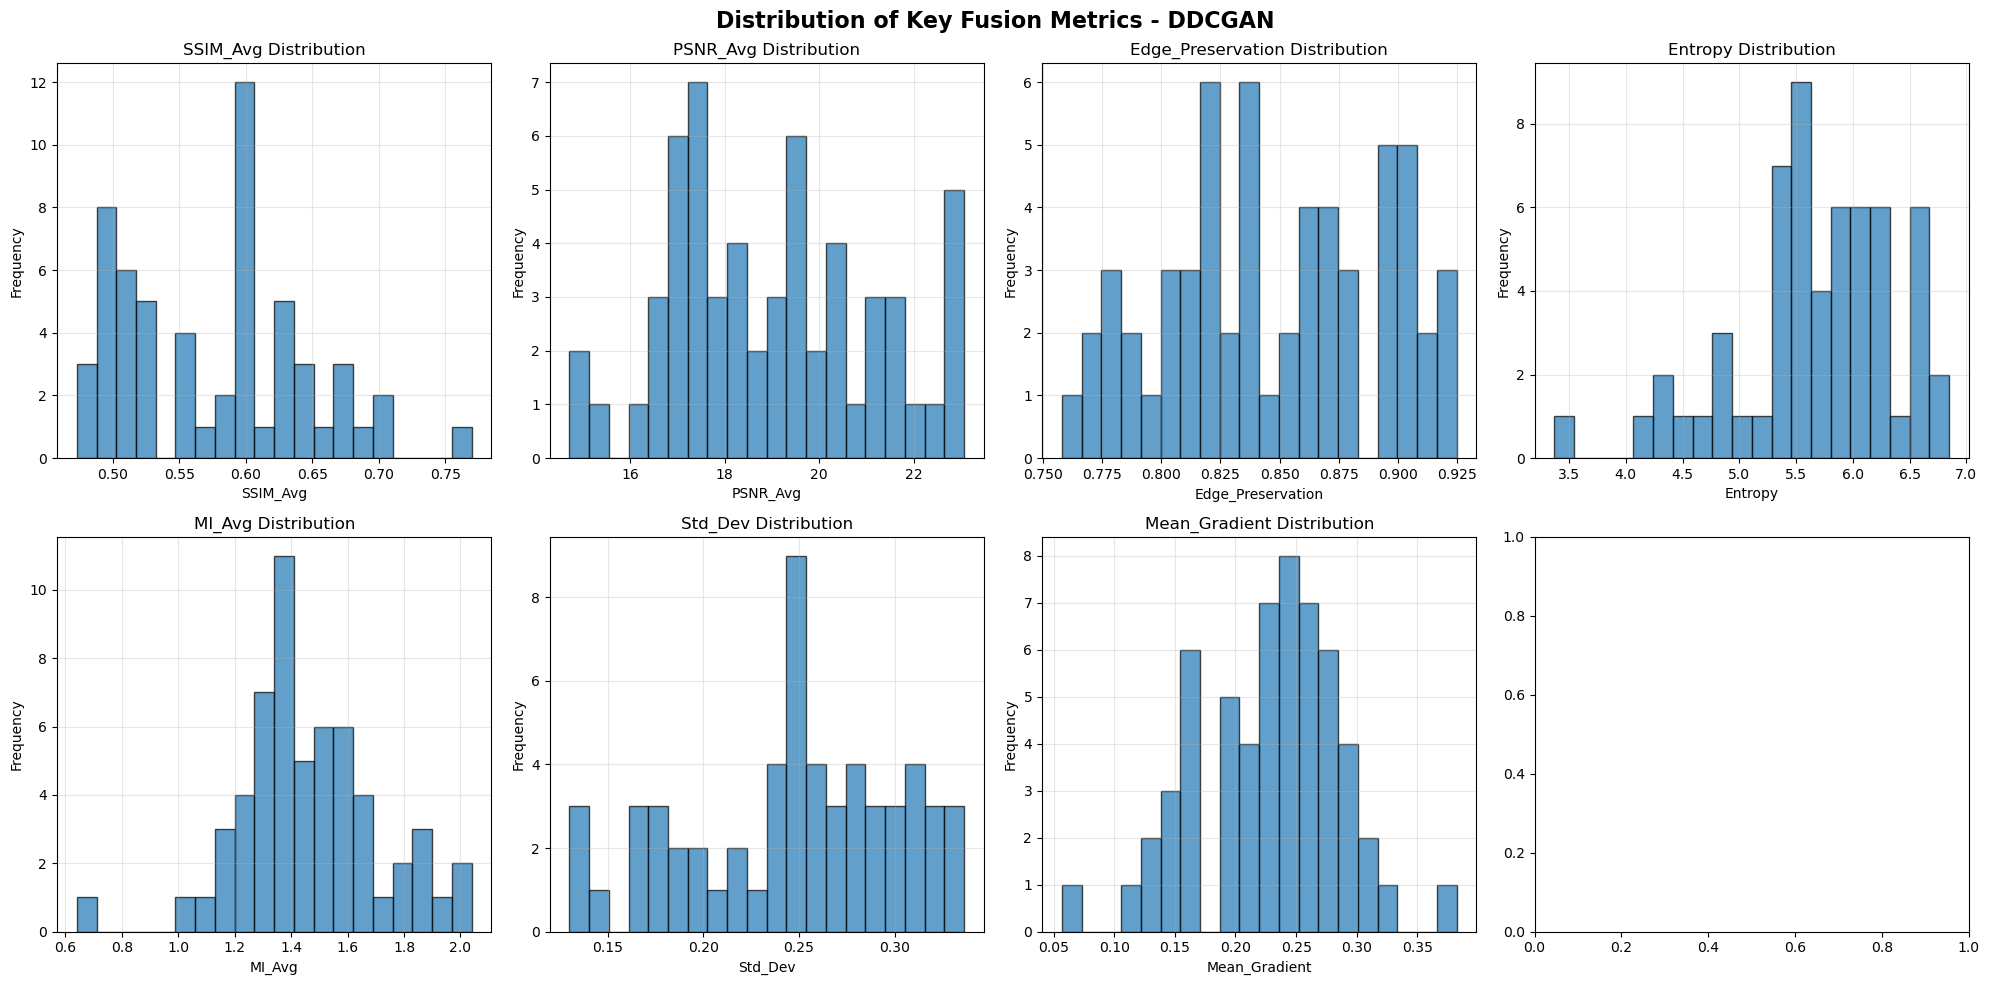

In [31]:
# Visualization of Results
print("Generating visualizations...")

# 1. Metrics Distribution Plot
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Distribution of Key Fusion Metrics - DDCGAN', fontsize=16, fontweight='bold')

key_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg', 'Std_Dev', 'Mean_Gradient']
for i, metric in enumerate(key_metrics):
    ax = axes[i//4, i%4]
    ax.hist(metrics_df[metric], bins=20, alpha=0.7, edgecolor='black')
    ax.set_title(f'{metric} Distribution')
    ax.set_xlabel(metric)
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'metrics_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

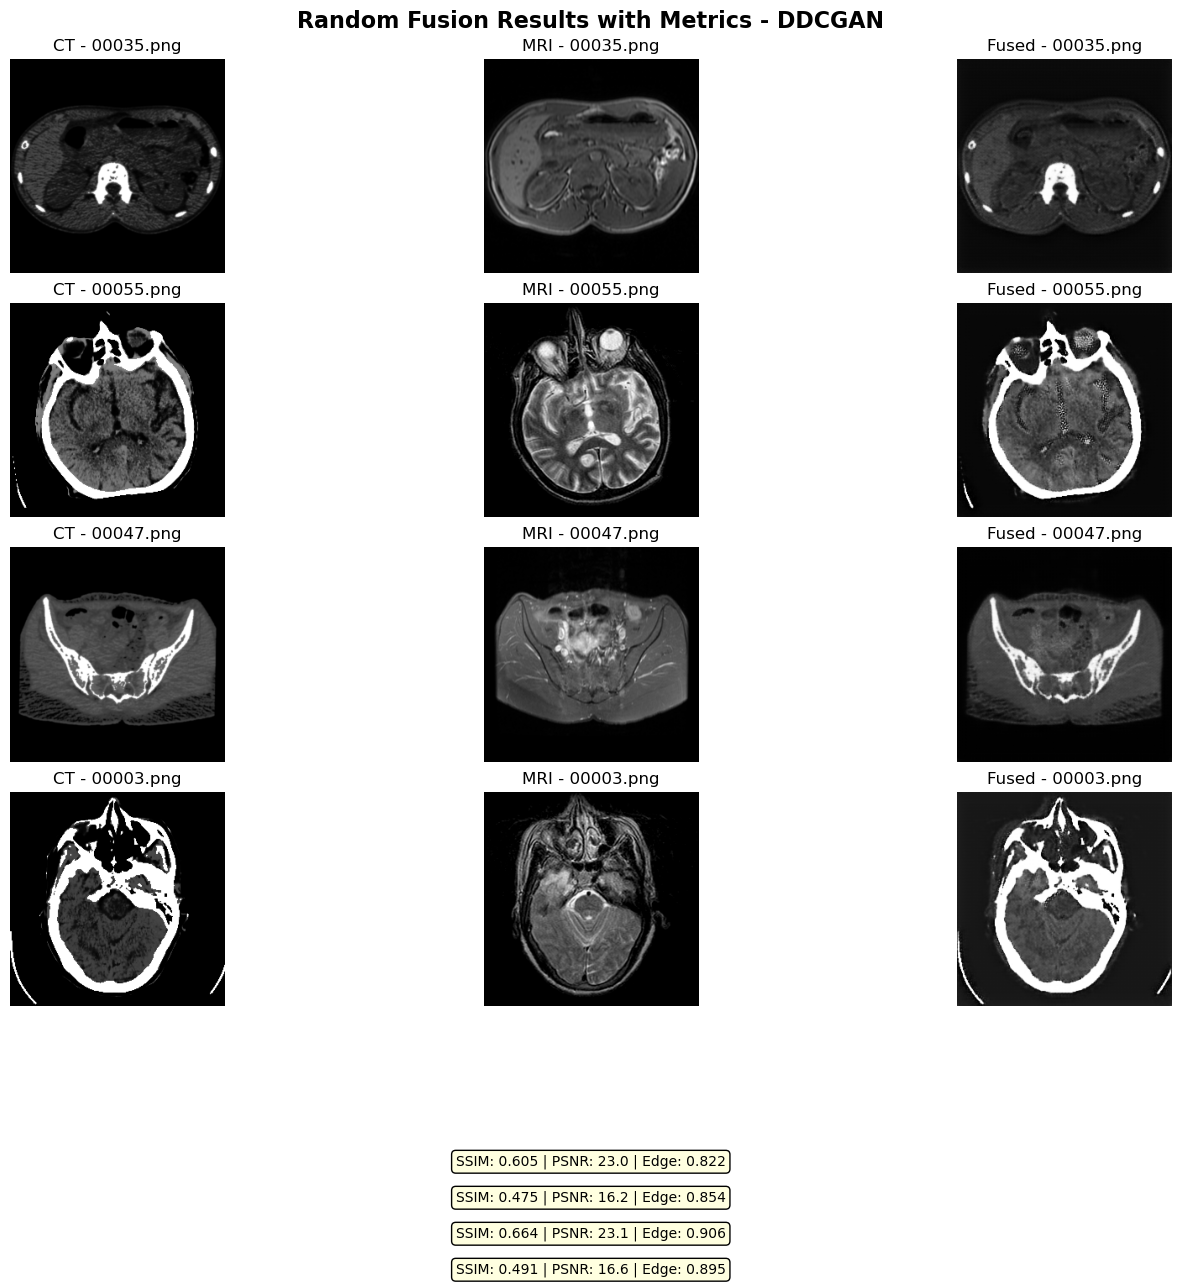


Detailed metrics for 4 random samples:

Sample 1: 00035.png
----------------------------------------
  SSIM_Avg       : 0.6047
  PSNR_Avg       : 23.0298
  Edge_Preservation: 0.8220
  Entropy        : 5.5072
  MI_Avg         : 1.3595

Sample 2: 00055.png
----------------------------------------
  SSIM_Avg       : 0.4753
  PSNR_Avg       : 16.2151
  Edge_Preservation: 0.8540
  Entropy        : 5.4650
  MI_Avg         : 1.3075

Sample 3: 00047.png
----------------------------------------
  SSIM_Avg       : 0.6645
  PSNR_Avg       : 23.0662
  Edge_Preservation: 0.9062
  Entropy        : 5.4439
  MI_Avg         : 1.6455

Sample 4: 00003.png
----------------------------------------
  SSIM_Avg       : 0.4907
  PSNR_Avg       : 16.5871
  Edge_Preservation: 0.8951
  Entropy        : 5.4651
  MI_Avg         : 1.1401


In [32]:
# 2. Random Fusion Results with Metrics
def display_random_fusion_results(test_results, all_metrics, num_samples=4, figsize=(16, 12)):
    """Display random fusion results with their evaluation metrics."""
    if len(test_results) == 0:
        print("No results available!")
        return

    # Select random indices
    random_indices = np.random.choice(len(test_results), min(num_samples, len(test_results)), replace=False)

    # Calculate grid dimensions
    cols = 3  # CT, MRI, Fused
    rows = len(random_indices)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle('Random Fusion Results with Metrics - DDCGAN', fontsize=16, fontweight='bold')

    for row_idx, idx in enumerate(random_indices):
        sample = test_results[idx]
        metrics = all_metrics[idx]

        # CT Image
        axes[row_idx, 0].imshow(sample['ct'], cmap='gray')
        axes[row_idx, 0].set_title(f'CT - {sample["key"]}')
        axes[row_idx, 0].axis('off')

        # MRI Image
        axes[row_idx, 1].imshow(sample['mr'], cmap='gray')
        axes[row_idx, 1].set_title(f'MRI - {sample["key"]}')
        axes[row_idx, 1].axis('off')

        # Fused Image
        axes[row_idx, 2].imshow(sample['fused'], cmap='gray')
        axes[row_idx, 2].set_title(f'Fused - {sample["key"]}')
        axes[row_idx, 2].axis('off')

        # Add metrics text below each row
        metrics_text = f"SSIM: {metrics.get('SSIM_Avg', 0):.3f} | PSNR: {metrics.get('PSNR_Avg', 0):.1f} | Edge: {metrics.get('Edge_Preservation', 0):.3f}"

        # Add text below the subplot
        fig.text(0.5, 0.02 - (row_idx * 0.03), metrics_text,
                ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for metrics text
    plt.savefig(os.path.join(results_dir, 'random_fusion_results.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Print detailed metrics for random samples
    print(f"\nDetailed metrics for {len(random_indices)} random samples:")
    print("=" * 80)
    for i, idx in enumerate(random_indices):
        sample = test_results[idx]
        metrics = all_metrics[idx]
        print(f"\nSample {i+1}: {sample['key']}")
        print("-" * 40)
        key_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg']
        for metric in key_metrics:
            if metric in metrics:
                print(f"  {metric:15}: {metrics[metric]:.4f}")

# Display random fusion results
display_random_fusion_results(test_results, all_metrics, num_samples=4)